## Projet IAS - Data Processing

In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Importation et filtrage les données

In [289]:
df = pd.read_csv('mouvement.csv', sep=';')
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062


**Explication du colonne 'BatchType'**

* BatchType = 1 : **Ajustement de stock** (positif ou négatif)

C'est un mouvement de stock qui est d'origine très variable. Il peut s'agir d'une erreur de vente/achat, d'un retour de produit, d'un produit périmé et aussi d'autres cas inexplicables, etc. Ce type de mouvement est pertinent car il indique l'état de stock de la pharmacie avant et après la vente.

* BatchType = 2 signifie **Transfert de stock** (neutre)

Il s'agit d'un mouvement de stock entre les emplacement internes de la pharmacie. Cela ne nous intéresse pas car il n'a aucun effet sur la variation du stock.

* BatchType = 3 signifie **Assortiment** (négatif car sortie de stock)
    Ce type de mouvement est pertinent car il indique l'états de stock de la pharamacie avant et après la vente.

* BatchType = 4 signifie une **Expédition**. 

Il indique la quantité de produits assortis prêts à être expédiés qui est appelé 'PICKED'. Ce mouvement ne nous intéresse pas car il est temporaire et n'a pas d'effet sur la variation du stock.
La suppression de ce mouvement est très importante car il s'apparie toujours au mouvement BatchType 3 (Assortiment). Donc ça va diminuer de moitié le nombre de lignes de ces deux catégories (3 et 4).

* BatchType = 5 signifie **Réapprovisionnement** (en général positif sauf erreur de saisie)

Il s'agit d'un mouvement de commander à nouveau des produits pour que le stock soit suffisant et permette de répondre à la demande. Cela aura un impact sur le stock de la pharmacie.

* BatchType = 6 signifie **Réception** (généralement positif sauf erreur de saisie)
Il s'agit d'un mouvement de stock qui indique que la pharmacie a reçu des produits achetés depuis les grossistes. Cela aura un impact sur le stock de la pharmacie.

Les lignes à éliminer sont celles qui ont BatchType = 2 et 4.

In [290]:
# Afficher les catégories de valeurs de la colonne 'BatchType'
df['BatchType'].unique()

array([6, 3, 4, 5, 1, 7, 2], dtype=int64)

In [291]:
# Comparer les nombres des 'BatchType' de catégorie 2 et 4 par rapport au total
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(1474451, 638706)

In [292]:
# Eliminer les lignes avec 'BatchType' 2 et 4
df = df[~df['BatchType'].isin([2, 4])]

In [293]:
# Vérification
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(835745, 0)

### 2. Remplir les 2 colonnes "last_stock" et "current_stock"

In [294]:
def fill_columns(row):
    if row['BatchType'] in [1, 5]:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 3:
        row['Quantity'] *= -1
        row['LastStock'] = row['FromQuantityBefore']
        row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 6:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    else:
        row['LastStock'] = 0
        row['CurrentStock'] = 0
    return row

In [295]:
# Create the two new columns and apply the function to each row
df['LastStock'] = 0
df['CurrentStock'] = 0
df = df.apply(fill_columns, axis=1)

# Display the updated DataFrame
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,0.0,2.0
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815,0.0,2.0
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,0.0,1.0


In [296]:
df.tail()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1474441,1507682,3,2025-04-06 16:43:31.793,-2.0,101.0,1.0,298.0,296.0,0.0,2.0,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,298.0,296.0
1474443,1507684,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,59.0,58.0,0.0,1.0,PARACETAMOL 500MG DET PL/10,3616,59.0,58.0
1474444,1507685,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,8.0,7.0,0.0,1.0,PRESA PRESERVATIF B/3,6590,8.0,7.0
1474447,1507688,3,2025-04-06 16:43:37.327,-1.0,101.0,1.0,79.0,78.0,0.0,1.0,NAUTAMINE 90MG CP DET SANOFI AVENTIS,3248,79.0,78.0
1474449,1507690,3,2025-04-06 16:43:39.933,-1.0,101.0,1.0,86.0,85.0,0.0,1.0,"SSI 0,9% FL/500ML POCHE PLASTIQUE",4342,86.0,85.0


In [297]:
df[(df['BatchType']==6) & df['FromLocationId'].isnull()].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0


In [298]:
df[(df['BatchType']==6) & df['FromLocationId']].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1299,1404,6,2019-08-12 11:50:31.353,-10.0,100.0,NaN,8.0,-2.0,NaN,NaN,YENDOL SACH DET,4934,8.0,-2.0
1376,1481,6,2019-08-12 13:12:08.780,-16.0,100.0,NaN,9.0,-7.0,NaN,NaN,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,9.0,-7.0


### 3. Mapping ProdId-Name

In [299]:
item_map = pd.read_csv('../data/ProductIdMapp.csv', sep=',')
item_map.head()

,ProdId,ItemName
0,100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...
1,102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE
2,103,804 BRULE GRAISSE SOL BUV STABILISATEUR FL/500ML
3,104,804 PACK MINCEUR
4,105,804 SOUPE B/300G LEGUMES


In [300]:
item_map.set_index('ProdId', inplace=True)
item_map = item_map.rename(columns={'ItemName': 'Name'})
item_map.head()

,Name
ProdId,
100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...
102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE
103,804 BRULE GRAISSE SOL BUV STABILISATEUR FL/500ML
104,804 PACK MINCEUR
105,804 SOUPE B/300G LEGUMES


### 4. Selection des produits selon **les quantités dynamiques** et les **nombres de mouvements**

**4.1. Calcule du quantité moyenne de surstock et du nombre de mouvement**

In [301]:
# Calculer la moyenne des quantités par produit
s_1 = df.copy()

s_1 = s_1[['ProdId', 'Quantity']].groupby('ProdId').agg(
    Moves=('ProdId', 'count'),
    QuantityMean=('Quantity', 'mean')
).reset_index()


In [302]:
s_1.head()

,ProdId,Moves,QuantityMean
0,100,77,0.025974
1,102,12,0.000000
2,103,4,0.000000
3,104,33,0.000000
4,105,26,0.038462


In [303]:
s_1.duplicated().sum()

0

In [304]:

s_1.sort_values(by='QuantityMean', ascending=False, inplace=True, ignore_index=True)
s_1.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [305]:
s_1.describe()

,ProdId,Moves,QuantityMean
count,5885.000000,5885.000000,5885.000000
mean,4189.507052,142.012744,0.425650
std,2280.022359,454.631319,7.839451
min,100.000000,1.000000,-9.315789
25%,2151.000000,8.000000,0.000000
50%,4420.000000,31.000000,0.000000
75%,6184.000000,124.000000,0.040541
max,7779.000000,16886.000000,250.000000


Text(0.5, 1.0, 'Scatter plot of Moves vs QuantityMean')

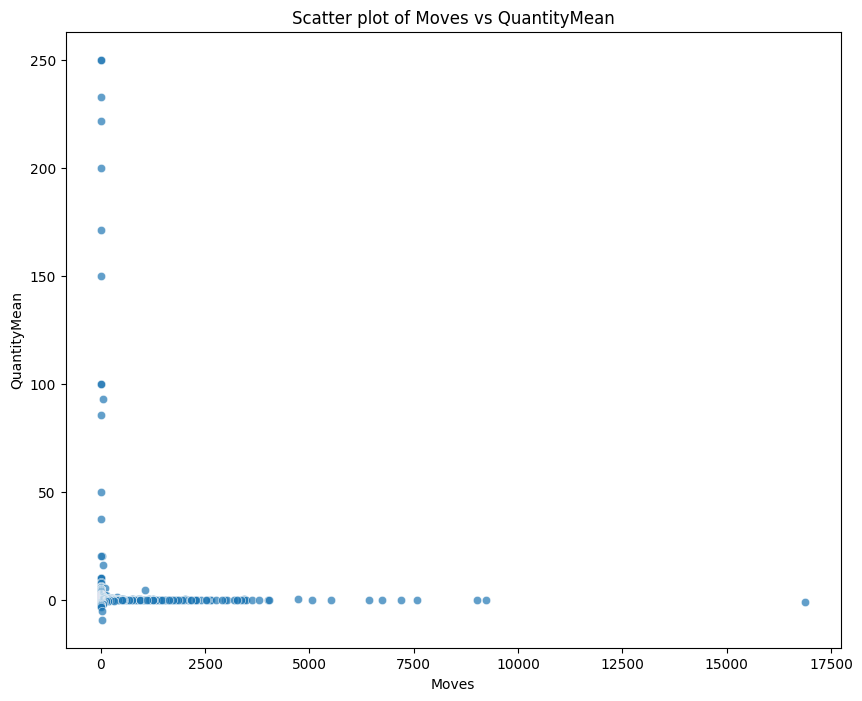

In [306]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=s_1,
    x='Moves',
    y='QuantityMean',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('Scatter plot of Moves vs QuantityMean')

D'après la visualisation, la plupart des produits en surstock ont peu de mouvements. Et ceux qui sont en forte rotation sont en général équilibrés en quantité de mouvements. Pour la suite, on va isoler l'étude des produits qui sont en surstock mais peu de mouvements par rapport aux reste.

**4.2. Construction d'un modèle de classification**

In [307]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [308]:
X = s_1[['Moves', 'QuantityMean']].values
print(X[:5])

XS = StandardScaler().fit_transform(X)

print(XS[:5])

[[  6.         250.        ]
 [  2.         250.        ]
 [ 12.         232.91666667]
 [  7.         221.57142857]
 [  1.         200.        ]]
[[-0.29919694 31.83839936]
 [-0.30799603 31.83839936]
 [-0.28599832 29.65906487]
 [-0.29699717 28.21174378]
 [-0.3101958  25.45985938]]


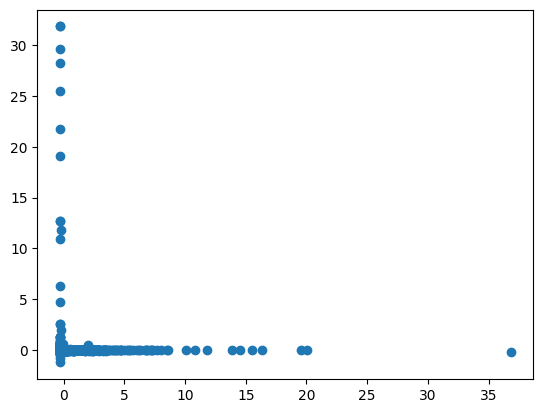

In [309]:
plt.scatter(XS[:, 0], XS[:, 1])
plt.show()

In [310]:
db = DBSCAN(eps=0.5, min_samples=5).fit(XS)

In [311]:
print(db.labels_)

[-1 -1 -1 ...  0  0  0]


In [314]:
s_2 = s_1.copy()
s_2['DB_Cluster'] = db.labels_
s_2.head()

,ProdId,Moves,QuantityMean,DB_Cluster
0,6222,6,250.000000,-1
1,5382,2,250.000000,-1
2,6214,12,232.916667,-1
3,5524,7,221.571429,-1
4,5559,1,200.000000,-1


In [315]:
s_2['DB_Cluster'].value_counts()

DB_Cluster
 0    5845
-1      29
 1      11
Name: count, dtype: int64

Text(0.5, 1.0, 'DBSCAN Clustering of Moves vs QuantityMean')

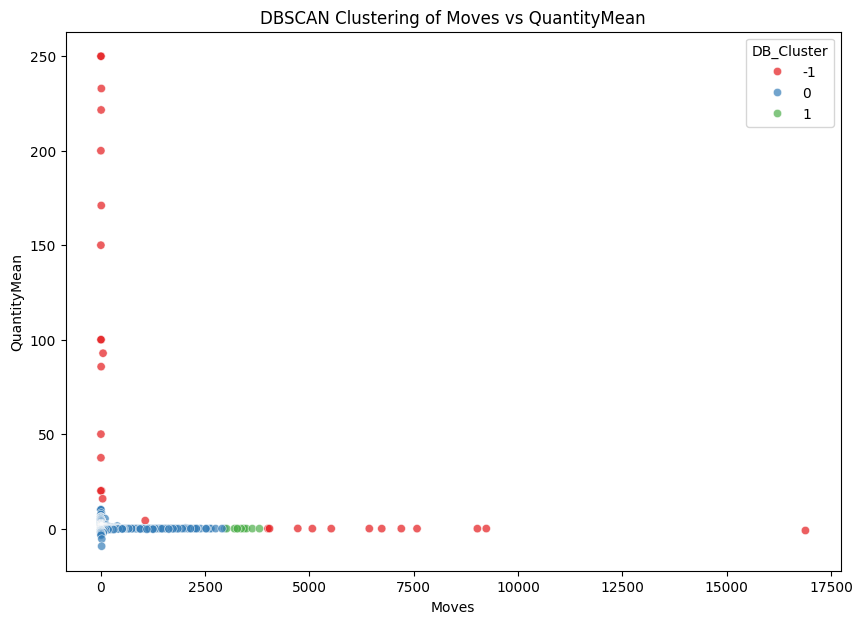

In [343]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='QuantityMean',
    hue='DB_Cluster',
    palette='Set1',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('DBSCAN Clustering of Moves vs QuantityMean')

In [344]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit(X)

KMeans(n_clusters=3, random_state=0)

In [345]:
# Assign the cluster labels to the DataFrame
s_2['KM_Cluster'] = km.labels_
s_2.head()

,ProdId,Moves,QuantityMean,DB_Cluster,KM_Cluster
0,6222,6,250.000000,-1,0
1,5382,2,250.000000,-1,0
2,6214,12,232.916667,-1,0
3,5524,7,221.571429,-1,0
4,5559,1,200.000000,-1,0


In [346]:
# Afficher les valeurs uniques des clusters
s_2['KM_Cluster'].value_counts()

KM_Cluster
0    5677
2     198
1      10
Name: count, dtype: int64

In [347]:
km.cluster_centers_

array([[ 8.61898890e+01,  4.40750999e-01],
       [ 7.84040000e+03, -8.82001805e-02],
       [ 1.35374242e+03,  1.86351977e-02]])

Text(0.5, 1.0, 'KMeans Clustering of Moves vs QuantityMean')

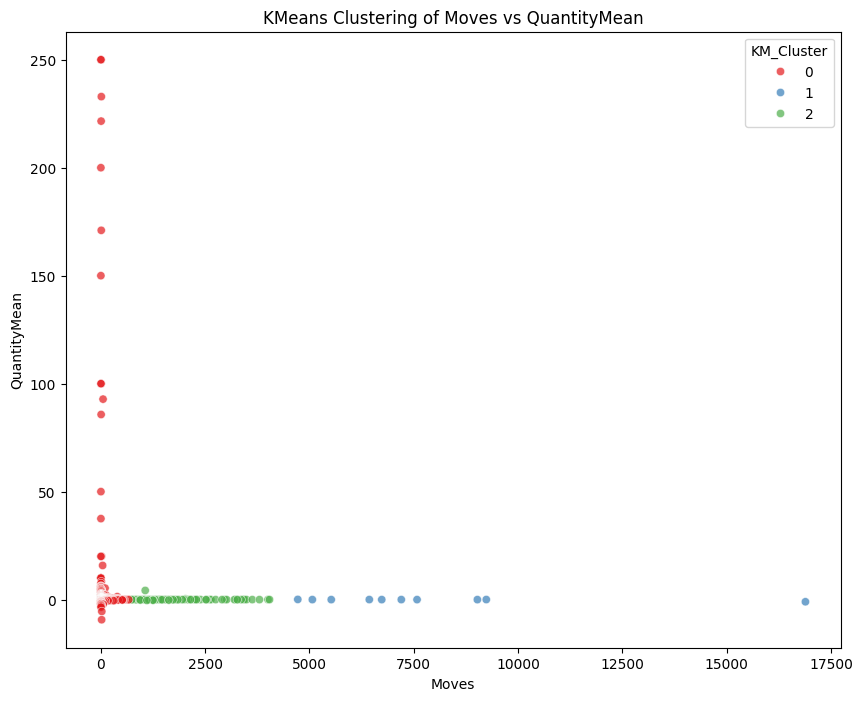

In [348]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='QuantityMean',
    hue='KM_Cluster',
    palette='Set1',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('KMeans Clustering of Moves vs QuantityMean')